# Homework 02 - Analysis of yellow taxis' rides in New York city


In [1]:
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import json
import folium
from branca.colormap import linear
import branca.colormap as cm
import seaborn as sns

## How to Clean Data
A fondamental step that is necessary to have more detailed and precise analysis is to clean up the initial given data. This means that in the millions of entries in the data we found a lot of weird values and we decided to cut them out from our analysis.

These are all the entries that have been deleted:
* Trips with a distance less or equal to zero. 
* The initial time of a trip must be strictly lower than the dropoff time.
* Total amount for a ride has to be greater ot at least equal to 3.3 dollars. This value is obtained from the (legend file)[http://www.nyc.gov/html/tlc/downloads/pdf/taxi_information.pdf] for taxis in New York, where is sated that there is an initial charge of 2.50 dollars plus 50 cent of State surcharge and 30 cent of improvement surcharge.
* There coulb be also errors with the dates. For this reason we heve controlled for each entry if the year is 2018 and that the month corresponds with the one that is being analyzed.
* We found some trips that has a long duration (i.e. more than 5 hours). We retained that a taxi trips can not be too long and for this reason we dropped all the trips longer than 3 hours.
* There were also very long rides, with houndres of miles as distance. We dropped all trips longer than 200 miles.
* The last thing that we dropped was the high rates for price over miles. We cut all the rates greater than 17.5 dollars per miles.

The initial data had size $53925735$ and the analyzed has size $52239189$.

The dropped lines are $1686546$ in total.

## RQ 1 - Taxi usage along the months

In [8]:
import pandas as pd
from datetime import datetime as dt
import calendar

In [9]:
files = ['F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-01.csv',
        'F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-02.csv',
        'F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-03.csv',
        'F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-04.csv',
        'F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-05.csv',
        'F:\\Hannes\\Yellow_Cab_Datasets\\yellow_tripdata_2018-06.csv']

Number of dropped cases for month January: 104756
Number of dropped cases for month February: 100406
Number of dropped cases for month March: 118897
Number of dropped cases for month April: 112666
Number of dropped cases for month May: 113477
Number of dropped cases for month June: 114512


Manhattan        48518782.0
Queens            3240037.0
Unknown            785730.0
Brooklyn           664877.0
Bronx               50736.0
Staten Island         485.0
EWR                   374.0
Total            53261021.0
Name: Total Trips, dtype: float64

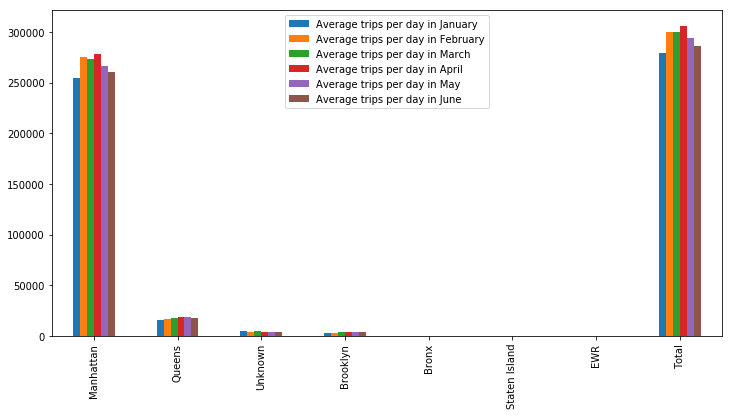

In [19]:
borough_trips = pd.DataFrame()
month = 1 
data2 = pd.read_csv("F:\\Hannes\\Yellow_Cab_Datasets\\taxi _zone_lookup.csv")
date_format = '%Y-%m-%d  %H:%M:%S'

for file in files:
    #reading files and cleaning data
    raw_data  = pd.read_csv(file)
    count_raw = raw_data.shape[0]
    raw_data['trip_duration'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime'], format = date_format) - pd.to_datetime(raw_data['tpep_pickup_datetime'], format = date_format)).astype('timedelta64[m]')
    raw_data = raw_data.drop(raw_data[(raw_data.trip_duration > 200 ) | (raw_data.trip_duration < 1 )].index)
    data_temp = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime == raw_data.tpep_pickup_datetime) | (raw_data.total_amount < 0) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != month) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018)].index) 
    del raw_data
    
    #number of cases dropped
    print('Number of dropped cases for month ' + calendar.month_name[month] + ': ' +str(count_raw - data_temp.shape[0]))
    
    #optaining columns to use for this request
    data = data_temp.loc[:, ['tpep_pickup_datetime', 'PULocationID', 'DOLocationID']]
    borough = data.join(data2.set_index('LocationID'), on='PULocationID')
    del data_temp
    
    if month == 1:
        #count the trips in every borough and in total and convert from series to dataframe
        borough_trips = borough['Borough'].value_counts() 
        borough_trips = borough_trips.to_frame(name = "Total Trips")
        borough_trips['Absolute trips ' + str(month)] = borough['Borough'].value_counts() 
        
        #convert pickup time to datetime format
        borough['tpep_pickup_datetime'] = pd.to_datetime(borough['tpep_pickup_datetime'])
        
        #divide borough_count with datetime (get days of a month according to a year from datetime) to get the average trips per day
        month_days = borough['tpep_pickup_datetime'].dt.daysinmonth
        month_days = month_days.to_frame(name = "Days_of_the_Month").tail(1).Days_of_the_Month.item()
        borough_trips['Average trips in month ' + str(month)] = borough['Borough'].value_counts() / month_days
        
        #sum for all the trips in all buroughs and save it to the dataframe borough_trips
        borough_trips.loc['Total', 'Absolute trips ' + str(month)]= borough_trips['Absolute trips ' + str(month)].sum()

        #calculate the average for all trips in the month and save it to the dataframe borough_trips
        borough_trips.loc['Total', 'Average trips in month ' + str(month)]= borough.shape[0] / month_days
        
    else:
        #count the trips in every borough and convert from series to dataframe
        borough_trips['Absolute trips ' + str(month)] = borough['Borough'].value_counts()
        borough_trips['Total Trips'] = borough_trips['Total Trips'] + borough['Borough'].value_counts() 
        
        #convert pickup time to datetime format
        borough['tpep_pickup_datetime'] = pd.to_datetime(borough['tpep_pickup_datetime'])
        
        #divide borough_count with datetime (get days of a month according to a year from datetime) to get the average trips per day
        month_days = borough['tpep_pickup_datetime'].dt.daysinmonth
        month_days = month_days.to_frame(name = "Days_of_the_Month").tail(1).Days_of_the_Month.item()
        borough_trips['Average trips in month ' + str(month)] = borough['Borough'].value_counts() / month_days
        
        #calculate the average for all trips in the month and save it to the dataframe borough_trips
        borough_trips.loc['Total', 'Absolute trips ' + str(month)]= borough_trips['Absolute trips ' + str(month)].sum()
        
        #sum for trips in all buroughs and save it to the dataframe borough_trips
        borough_trips.loc['Total', 'Average trips in month ' + str(month)]= borough.shape[0] / month_days
                      
    month = month + 1 
    
#get the sum of all trips    
borough_trips.loc['Total', 'Total Trips']= borough_trips['Total Trips'].sum()

#plot everything in one beautiful plot
plo = borough_trips.plot.bar(y = ['Average trips in month 1', 'Average trips in month 2', 'Average trips in month 3','Average trips in month 4','Average trips in month 5','Average trips in month 6'], figsize=(12,6), legend=("upper left"))
mylabels = ['Average trips per day in January', 'Average trips per day in February', 'Average trips per day in March','Average trips per day in April','Average trips per day in May','Average trips per day in June']
plo.legend(loc=9,fontsize=10,fancybox=True, labels=mylabels)
display(borough_trips['Total Trips'])


## RQ 2 - Taxi usage during a day

## RQ 3 - Duration of taxis' rides
This task has the aim to describe and illustrates the main characteristics of the duration of the trips during the first semester of 2018 in the whole City and to point out the differences between all the boroughs.  
In order to solve this problem we made some assumptions:
* In the borough part we have decided to keep in the plots the 'Unknown' borough. This has been decided because in the data the number of trips with this property is strongly significant. 

* All the analysis of trips duration is based on 4 different timeslot, that are: 

   1. Short trips: last in less or equal than 10 minutes.
   2. Medium-short trips: between 10 and 20 minutes.
   3. Medium-long trips: between 20 and 40 minutes.
   4. Long trips: last in more than 40 minutes.

In order to solve the task, there are three main steps to be computed:

   1. Retrieve data of the different from the files.
   2. Analysis of the whole Ney York
   3. Analysis through all the Boroughs


In [2]:
#global variables 
FMT = '%Y-%m-%d  %H:%M:%S'
data2 = pd.read_csv("taxi _zone_lookup.csv")
b = ['Manhattan', 'Queens', 'EWR', 'Bronx', 'Staten Island', 'Brooklyn', 'Unknown']
p1 = {}
p2 = {}
p3 = {}
p4 = {}

### Retrieve data of different months from the files.
In this first part we pass through all the data present in the different files.  
At the beginning it is necessary to initialize our variables loading the January file and cleaning up it (as it was described before). 

In [3]:
#initializing variables with JANUARY, whole NY

# retieving data to be cleaned
raw_data  = pd.read_csv("yellow_tripdata_2018-01.csv")

# cleaning data
raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != 1) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

# free memory deleting the raw_data
del raw_data

# taking only the columns that I need
data = data.loc[:, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID']]

Due to division of trips duration into 4 timeslots, we have calculated that for each trip present in the dataset. 
The variable `delta` represents the duration, in minutes, of any single trip.

In [4]:
pickup_time = pd.to_datetime(data['tpep_pickup_datetime'].str.strip(), format = FMT)
dropoff_time = pd.to_datetime(data['tpep_dropoff_datetime'].str.strip(), format = FMT)
delta = (dropoff_time - pickup_time).astype('timedelta64[m]')

del pickup_time
del dropoff_time

In [5]:
#initializing variables with JANUARY, each Borough

borough = data.join(data2.set_index('LocationID'), on='PULocationID')

del data

for i in b:
    bor = borough[borough.Borough == i]
    pickup_time = pd.to_datetime(bor['tpep_pickup_datetime'].str.strip(), format = FMT)
    dropoff_time = pd.to_datetime(bor['tpep_dropoff_datetime'].str.strip(), format = FMT)
    delta_b = (dropoff_time - pickup_time).astype('timedelta64[m]')
    
    agg = pd.DataFrame(delta_b.value_counts(), columns = ['y'])
    agg = agg[agg.index >= 0]
    
    less_ten = agg[agg.index <= 10].sort_index()
    try:
        pr1 = (less_ten.cumsum() / delta.size).tail(1).y.item()
    except:
        pr1 = 0
    p1[i] = pr1 
    less_twenty = agg[agg.index <= 20]
    less_twenty = less_twenty[less_twenty.index > 10].sort_index()
    try:
        pr2 = (less_twenty.cumsum() / delta.size).tail(1).y.item()
    except:
        pr2 = 0
    p2[i] = pr2 
    more = agg[agg.index > 20]
    more = more[more.index <= 30].sort_index()
    try :
        pr3 = (more.cumsum() / delta.size).tail(1).y.item()
    except:
        pr3 = 0
    p3[i] = pr3 
    more_hour = agg[agg.index > 30].sort_index()
    try :
        pr4 = (more_hour.cumsum() / delta.size).tail(1).y.item()
    except:
        pr4 = 0
    p4[i] = pr4


The same procedure used in the initialization step with January is then applied to all the other months. 
At the end of this loop, for the whole city part, we saved the number of trips for all 1-minute timeslots.
Instead, for the boroughs part, we kept for each borough the average percentages of the 4 timeslots presented before.  

In [6]:
#retriving data in each month of 2018

for i in range(2,7):
        # retieving data to be cleaned
        raw_data  = pd.read_csv("yellow_tripdata_2018-0"+str(i)+".csv")

        # cleaning data
        raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
        data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != i) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

        # free memory deleting the raw_data
        del raw_data

        # taking only the columns that I need
        data = data.loc[:, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID']]
    
        pickup_time = pd.to_datetime(data['tpep_pickup_datetime'].str.strip(), format = FMT)
        dropoff_time = pd.to_datetime(data['tpep_dropoff_datetime'].str.strip(), format = FMT)
        delta = delta.append((dropoff_time - pickup_time).astype('timedelta64[m]'))
        del pickup_time
        del dropoff_time
        agg = pd.DataFrame(delta.value_counts(), columns = ['number_of_rides'])
        agg = agg[agg.index >= 0]
                
        borough = data.join(data2.set_index('LocationID'), on='PULocationID')
        del data
        
        #looking for timeslots data in each borough        
        for i in b:
            bor = borough[borough.Borough == i]
            pickup_time = pd.to_datetime(bor['tpep_pickup_datetime'].str.strip(), format = FMT)
            dropoff_time = pd.to_datetime(bor['tpep_dropoff_datetime'].str.strip(), format = FMT)
            delta_b = (dropoff_time - pickup_time).astype('timedelta64[m]')
    
            agg = pd.DataFrame(delta_b.value_counts(), columns = ['y'])
            agg = agg[agg.index >= 0]
    
            less_ten = agg[agg.index <= 10].sort_index()
            try:
                pr1 = (less_ten.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr1 = 0
            p1[i] = (p1[i] + pr1) /2
            less_twenty = agg[agg.index <= 20]
            less_twenty = less_twenty[less_twenty.index > 10].sort_index()
            try:
                pr2 = (less_twenty.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr2 = 0
            p2[i] = (p2[i] + pr2) /2
            more = agg[agg.index > 20]
            more = more[more.index <= 40].sort_index()
            try :
                pr3 = (more.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr3 = 0
            p3[i] = (p3[i] + pr3) /2
            more_hour = agg[agg.index > 40].sort_index()
            try :
                pr4 = (more_hour.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr4 = 0
            p4[i] = (p4[i] + pr4) /2
del data2

### Analysis of the whole Ney York


In this part, we illustrates through graphs the distribution of the trips duration through the City. 

The table shows the 1-minute timeslots and the related number of trips.

The first plot represents the distribution of the trips from 0 to 60 minutes. It can be seen that the highest number of rides last in the firts 10 minutes. The maximum is reached by the trip that last in 6 minutes. 
The graph also shows that the rides seem to exponentially decrease as longer they become.

[Text(0, 0.5, 'Number of trips'), Text(0.5, 0, 'Duration (minutes)')]

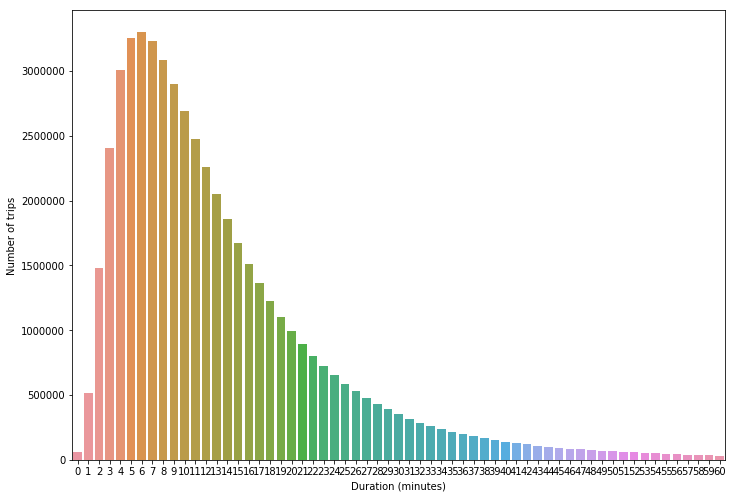

In [7]:
#creating the dataframe. Each column of the plot represents a 1-minute timeslot (ascending order)
agg = pd.DataFrame(delta.value_counts(), columns = ['number_of_rides'])
agg = agg[agg.index >= 0]
agg.index = agg.index.astype(int)
distro = agg[agg.index <= 60]
distro = distro.sort_index()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(x = distro.index, y = 'number_of_rides', data=distro, )
ax.set(xlabel='Duration (minutes)', ylabel='Number of trips')


This code is used to divide the all the 1-minute timeslots into the 4 timeslots.

In [8]:
#rides that least less than 10 minutes
less_ten = agg[agg.index <= 10]
less_ten = less_ten.sort_index()
percent1 = (less_ten.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more than 10 minutes and less 20 minutes
less_twenty = agg[agg.index <= 20]
less_twenty = less_twenty[less_twenty.index > 10]
less_twenty = less_twenty.sort_index()
percent2 = (less_twenty.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more than 20 minutes and less than 40 minutes
more = agg[agg.index > 20]
more = more[more.index <= 40]
more = more.sort_index()
percent3 = (more.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more 40 minutes
more_hour = agg[agg.index > 40] 
more_hour = more_hour.sort_index()
percent4 = (more_hour.cumsum() / delta.size).tail(1).number_of_rides.item()

A relevant information about the distribution of the various durations can be seen thanks to the pie chart. 
Here is shown the contrast that is present between short and long rides. The half of all the trips is formed by the less-than-10-minutes trips. It is also highlited that the short and the medium-short rides are the 80% of the total. 

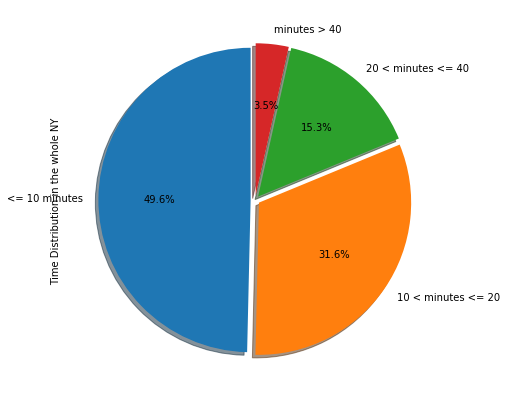

In [9]:
d = {'Time Distribution in the whole NY': [percent1, percent2, percent3, percent4]}
df = pd.DataFrame(data=d, index=['<= 10 minutes', '10 < minutes <= 20', '20 < minutes <= 40', 'minutes > 40'])
plt.figure(figsize=(7,7))
explode = (0.03, 0.03, 0.03, 0.03) 
df['Time Distribution in the whole NY'].plot.pie(autopct='%1.1f%%', explode = explode, startangle=90, shadow=True, legend = False, fontsize=10)

### Analysis through all the Boroughs
In this part we focused our attention in the differences present through the NY's boroughs.
First of all the table represented percentages-per-timeslots for each borough was created. 

In [10]:
# create dataframes from dictionaries with percentages for each boroughs
my1 = pd.DataFrame.from_dict(p1, orient='index', dtype=None, columns=['<= 10 min'])
my2 = pd.DataFrame.from_dict(p2, orient='index', dtype=None, columns=['10 < min <= 20'])
my3 = pd.DataFrame.from_dict(p3, orient='index', dtype=None, columns=['20 < min <= 40'])
my4 = pd.DataFrame.from_dict(p4, orient='index', dtype=None, columns=['min > 40'])

# joining the dataframes
result = pd.concat([my1, my2, my3], axis=1)
my4 = my4.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my4)
result = result.rename(index={0: 'Manhattan', 1: 'Queens', 2: 'EWR', 3:'Bronx', 4: 'Staten Island', 5:'Brooklyn', 6:'Unknown'})

result

,<= 10 min,10 < min <= 20,20 < min <= 40,min > 40
Manhattan,0.506962,0.328164,0.141510,0.020596
Queens,0.092294,0.145545,0.401409,0.331365
EWR,0.570856,0.071056,0.155915,0.170924
Bronx,0.317644,0.278729,0.244007,0.128393
Staten Island,0.257170,0.142798,0.212865,0.355917
Brooklyn,0.401287,0.322911,0.199381,0.045526
Unknown,0.469813,0.308022,0.154013,0.037428


The following bar chart shows borough per bourough how the timeslots percentages differ. 
It can be seen that the percentages of the boroughs are diffent from what we said about the whole city. It seems that only Manhattan (and the Unknown one) reflects the proportion found before. 
In two boroughs, Queens and Staten Island, the short trips are not the highest percentage but, respectvively, the medium-long and the long trips.
In the EWR zones the short rides reach almost the 60%, that is almolst 10% more of the average of short trips in the whole City.  

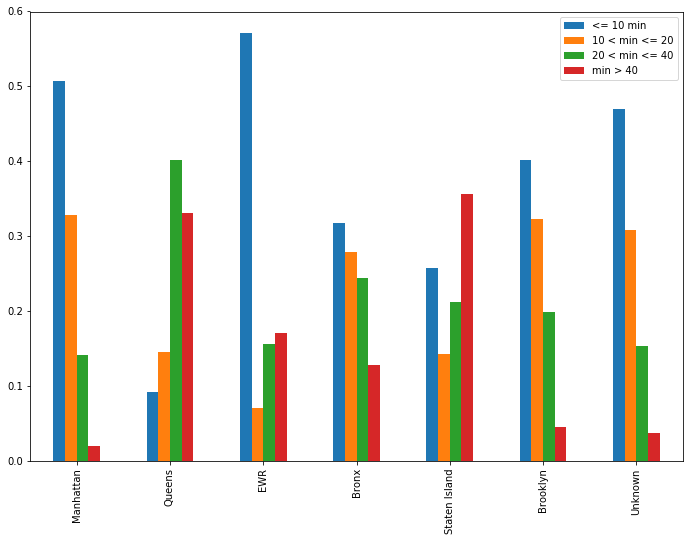

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = result.plot.bar(ax =ax)
ax

## RQ 4 - Most used payment method
In this we focus our attention on the various payment method that could be use for each trip. The main task is to look into the data and point out the most important characteristics in the entire New York City and in the single Boroughs. 
A significant result for this task is given by running the Chi-Squared test over the payment methods and the boroughs.  

To complete this analysis we assume that: 
* In the borough part we have decided to keep in the plots the 'Unknown' borough. This has been decided because in the data the number of trips with this property is strongly significant. 
* Due to the fact that almost all the transactions are done via credit card or cash, we consider only this two method for the chi-squared part

In order to solve the task, there are four main steps to be computed:

   1. Retrieve data of the different from the files.
   2. Analysis of the whole Ney York
   3. Analysis of all the Boroughs
   4. Chi-squared analysis

In [2]:
# global variables
data2 = pd.read_csv("taxi _zone_lookup.csv")
b = ['Manhattan', 'Queens', 'EWR', 'Bronx', 'Staten Island', 'Brooklyn', 'Unknown']
p1 = {}
p2 = {}
p3 = {}
p4 = {}
p5 = {}
p6 = {}
p1_chi = {}
p2_chi = {}
p3_chi = {}
p4_chi = {}
p5_chi = {}
p6_chi = {}

### Retrieve data of different months from the files.
In this first part we pass through all the data present in the different files.  
At the beginning it is necessary to initialize our variables loading the January file and cleaning it up, with the filters that have been described before. 

In [3]:
#WHOLE NY - JANUARY
# retieving data to be cleaned
raw_data  = pd.read_csv("yellow_tripdata_2018-01.csv")

# cleaning data
raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != 1) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 
m=raw_data.index.size
n = data.index.size

# free memory deleting the raw_data
del raw_data

# taking only the columns that I need
data = data.loc[:, ['payment_type', 'PULocationID', 'trip_distance']]

#counting transactions per payment type
ex = data.groupby('payment_type').count()

borough = data.join(data2.set_index('LocationID'), on='PULocationID')

del data

for i in b:
    bor = borough[borough.Borough == i]
    
    #find probabilities for each borough in January
    p1[i] = bor[bor.payment_type == 1].payment_type.count() / bor.index.size
    p2[i] = bor[bor.payment_type == 2].payment_type.count() / bor.index.size
    p3[i] = bor[bor.payment_type == 3].payment_type.count() / bor.index.size
    p4[i] = bor[bor.payment_type == 4].payment_type.count() / bor.index.size
    p5[i] = bor[bor.payment_type == 5].payment_type.count() / bor.index.size
    p6[i] = bor[bor.payment_type == 6].payment_type.count() / bor.index.size
    
    #counting payment type for rides for CHI analysis, each Borough in January
    p1_chi[i] = (bor[bor.payment_type == 1].payment_type.count())
    p2_chi[i] = (bor[bor.payment_type == 2].payment_type.count())
    p3_chi[i] = (bor[bor.payment_type == 3].payment_type.count())
    p4_chi[i] = (bor[bor.payment_type == 4].payment_type.count())
    p5_chi[i] = (bor[bor.payment_type == 5].payment_type.count())
    p6_chi[i] = (bor[bor.payment_type == 6].payment_type.count())

The same procedure used in the initialization step with January is then applied to all the other months. 
At the end of this loop, for the whole city part, we saved the number of transactions for each payment method.

For the boroughs part, we kept for each borough the average percentages of the six different ways to pay.

As regards the chi-squared analysis we stored for each borough the amount of transactions for each method. 

In [4]:
for i in range(2,7):
        # retieving data to be cleaned
        raw_data  = pd.read_csv("yellow_tripdata_2018-0"+str(i)+".csv")
        m = m + raw_data.index.size
        # cleaning data
        raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
        data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != i) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 
        n = n + data.index.size
        # free memory deleting the raw_data
        del raw_data
        
        
        data = data.loc[:, ['payment_type', 'PULocationID', 'trip_distance']]
        
        #counting frequecncies for each payment type in the whole NY
        ex['trip_distance'] = ex['trip_distance'] + (data.groupby('payment_type').count())['trip_distance']
        
        borough = data.join(data2.set_index('LocationID'), on='PULocationID')

        del data
        
        for i in b:
            bor = borough[borough.Borough == i]
            
            #find probabilities for each borough (for Borough analysis)
            p1[i] = (p1[i] + (bor[bor.payment_type == 1].payment_type.count() / bor.index.size)) / 2
            p2[i] = (p2[i] + (bor[bor.payment_type == 2].payment_type.count() / bor.index.size)) / 2
            p3[i] = (p3[i] + (bor[bor.payment_type == 3].payment_type.count() / bor.index.size)) / 2
            p4[i] = (p4[i] + (bor[bor.payment_type == 4].payment_type.count() / bor.index.size)) / 2
            p5[i] = (p5[i] + (bor[bor.payment_type == 5].payment_type.count() / bor.index.size)) / 2
            p6[i] = (p6[i] + (bor[bor.payment_type == 6].payment_type.count() / bor.index.size)) / 2
              
            #counting frequencies of payment types in each Borough (for CHI analysis)
            p1_chi[i] = p1_chi[i] + (bor[bor.payment_type == 1].payment_type.count())
            p2_chi[i] = p2_chi[i] + (bor[bor.payment_type == 2].payment_type.count())
            p3_chi[i] = p3_chi[i] + (bor[bor.payment_type == 3].payment_type.count())
            p4_chi[i] = p4_chi[i] + (bor[bor.payment_type == 4].payment_type.count())
            p5_chi[i] = p5_chi[i] + (bor[bor.payment_type == 5].payment_type.count())
            p6_chi[i] = p6_chi[i] + (bor[bor.payment_type == 6].payment_type.count())


### Analysis of the whole Ney York
In this section we are focusing on the usage of the payment methods in New York.

As the following table shows, there are two ways of payment, Credit card and Cash, that are extremely higher than the others. In effect these two are in the order of 10-milions transactions, in contrast with the maximum 200,000 transactions of the others.     

In [5]:
ex = ex.rename(index={1: 'Credit_card', 2: 'Cash', 3: 'No_charge', 4:'Dispute'}, columns = {'trip_distance' : 'transactions'}).loc[:, ['transactions']]
ex

,transactions
payment_type,
Credit_card,36557855
Cash,15423940
No_charge,200223
Dispute,57171


What we have just said is illustrated by this bar chart. We can see that the the only visible methods are credit card and cash. 

We also notice that the credit card way is used more than two times than the number of the cash transactions.

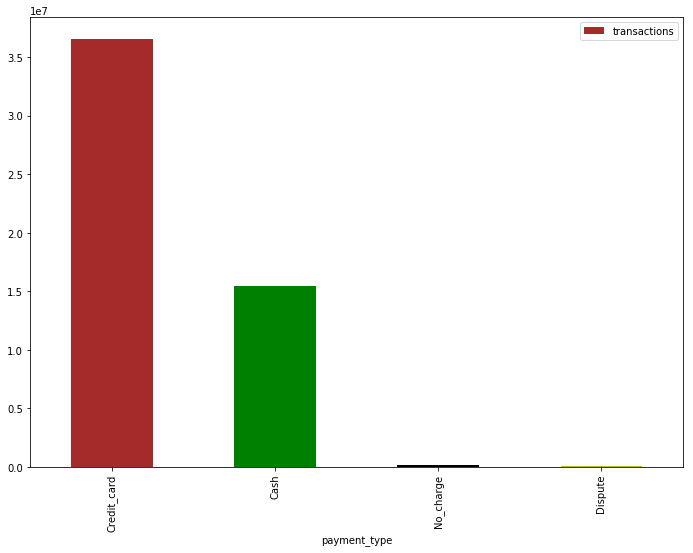

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = ex.plot.bar(ax =ax, color= ('brown', 'g', 'black', 'y'))
ax

The following pie chart is foundamental to see the distribution in percentage of the various methods. 

The sum of credit card and cash is the almost the 100% of the total transaactions, precisely they are the 99.5%. It is also noticeable that the number of credit card is 10% more than the double of the cash usage.

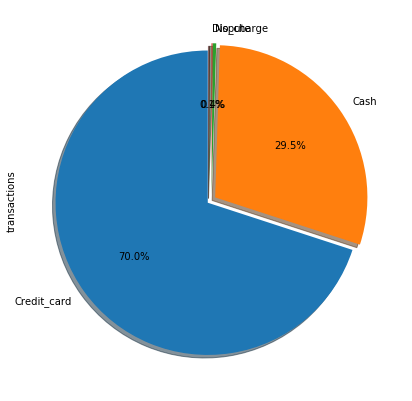

In [7]:
plt.figure(figsize=(7,7))
explode = (0.03, 0.03, 0.03, 0.03) 
#ax1 = plt.subplot(121, aspect='equal')
ex['transactions'].plot.pie(autopct='%1.1f%%', explode = explode, startangle=90, shadow=True, legend = False, fontsize=10)


### Analysis of all the Boroughs
The third part of this task deals with the borough analysis.

Here we are interesting to show all the differences that are relevant between all the boroughs. A problem that occurs dealing with boroughs is the really high of trips in Manhattan. To handle this problem it was necessary to 'normalize' data in percentage. The table that follows reports all the percentages for boroughs and payment methods.

In [8]:
#converting dictionaries to Dataframes

my1 = pd.DataFrame.from_dict(p1, orient='index', dtype=None, columns=['Credit_card'])
my2 = pd.DataFrame.from_dict(p2, orient='index', dtype=None, columns=['Cash'])
my3 = pd.DataFrame.from_dict(p3, orient='index', dtype=None, columns=['No_charge'])
my4 = pd.DataFrame.from_dict(p4, orient='index', dtype=None, columns=['Dispute'])
my5 = pd.DataFrame.from_dict(p5, orient='index', dtype=None, columns=['Unknown'])
my6 = pd.DataFrame.from_dict(p6, orient='index', dtype=None, columns=['Voided trip'])

#Merging the Dataframes
result = pd.concat([my1, my2, my3], axis=1)
my4 = my4.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my4)
my5 = my5.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my5)
my6 = my6.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my6)
result = result.rename(index={0: 'Manhattan', 1: 'Queens', 2: 'EWR', 3:'Bronx', 4: 'Staten Island', 5:'Brooklyn', 6:'Unknown'})
result

,Credit_card,Cash,No_charge,Dispute,Unknown,Voided trip
Manhattan,0.698820,0.296527,0.003585,0.001068,0.0,0.0
Queens,0.695749,0.295718,0.006628,0.001905,0.0,0.0
EWR,0.674975,0.240984,0.069966,0.014075,0.0,0.0
Bronx,0.571328,0.414928,0.010643,0.003100,0.0,0.0
Staten Island,0.663859,0.290052,0.037775,0.008315,0.0,0.0
Brooklyn,0.659672,0.330677,0.007710,0.001941,0.0,0.0
Unknown,0.693169,0.296767,0.008655,0.001409,0.0,0.0


The bar chart illustrates the distribution of all the zones. It can be seen that all the borough seem to follow what we had discovered in the precedent section of the whole City. The highest percentages is always the credit card method that lays more or less in the 65%. The lower value for credit card is the Bronx one, in which there is the highest percentage of cash transactions.   

The other types of payment do not reach a relevant value.

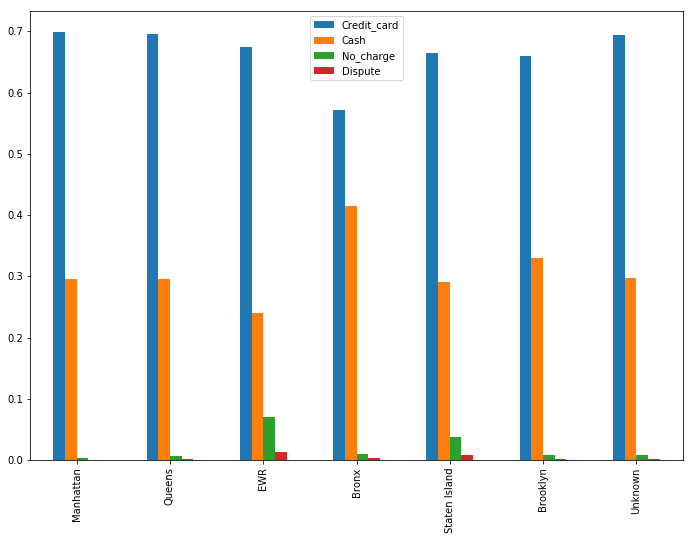

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = result.plot.bar(ax =ax, y = ['Credit_card', 'Cash','No_charge', 'Dispute'])
ax
#result.plot.bar(y = ['Credit_card', 'Cash','No_charge', 'Dispute'])

Then here is shown the box chart in order to see how the percentages are distributed through the Boroughs.

This graphs is important because we can see where the median is for each type of payment and also if there are cases that are distributed in a differnt way.

We take the Credit card as an example. We can deduce from the graph that all the value of that method are between 65% and 70%. There is only an outcomes that is distant from this value, 57%, that is the Bronx one mentioned before.

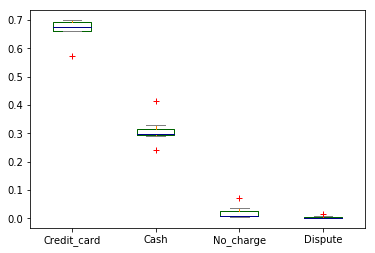

In [10]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
result.plot.box(y = ['Credit_card', 'Cash','No_charge', 'Dispute'], color = color, sym='r+')

The area chart illustrates with colors how the different methods are present in the data. We can notice that the blu (Credit card) and orange (cash) fill almost the whole figure.  

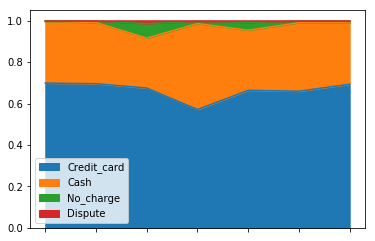

In [11]:
result.plot.area(y = ['Credit_card', 'Cash','No_charge', 'Dispute'])

### Chi-Squared analysis
This section deals with the statistical result that comes from the chi-squared analysys. 

Chi-squared is an important statistic test that allowed us to reject the initial hypothesys that was 'The Boroughs and payment type are not correlated'. Rejecting this hypothesis we discovered that there is a correlation between the different zones of New York and the type of payment used.

As we mentioned before, we decided to keep only the credit card and the cash methods because they are the only relevant ones. 

This first lines are used to prepared the dataframes for the test.

In [12]:
#Converting dictionaries to Dataframes
my1 = pd.DataFrame.from_dict(p1_chi, orient='index', dtype=None, columns=['Credit_card'])
my2 = pd.DataFrame.from_dict(p2_chi, orient='index', dtype=None, columns=['Cash'])
my3 = pd.DataFrame.from_dict(p3_chi, orient='index', dtype=None, columns=['No_charge'])
my4 = pd.DataFrame.from_dict(p4_chi, orient='index', dtype=None, columns=['Dispute'])
my5 = pd.DataFrame.from_dict(p5_chi, orient='index', dtype=None, columns=['Unknown'])
my6 = pd.DataFrame.from_dict(p6_chi, orient='index', dtype=None, columns=['Voided trip'])

#Merging the Dataframes in a single one
result = pd.concat([my1, my2, my3], axis=1)
my4 = my4.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my4)
my5 = my5.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my5)
my6 = my6.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my6)
result = result.rename(index={0: 'Manhattan', 1: 'Queens', 2: 'EWR', 3:'Bronx', 4: 'Staten Island', 5:'Brooklyn', 6:'Unknown'})


The table that follows contains all the transaction done via credit card or cash divided into the seven boroughs (six real + the Unknown one). As the other times, it is visible that Manhattan hash the highest number of transactions. 

In [13]:
#taking only the two main payment types
chi = result.loc[:, ['Credit_card', 'Cash']]
chi

,Credit_card,Cash
Manhattan,33305733,14014142
Queens,2260861,938173
EWR,291,104
Bronx,26251,23055
Staten Island,293,165
Brooklyn,431195,220445
Unknown,533231,227856


The code that follows is the implementation of the chi-squared test. 

The initial hypothesis is: 'The Boroughs and payment type are not correlated' 

In [14]:
#variables to find the Chi Squared value
chi_cc = chi.Credit_card.sum()   #total of val in Credit_card 
chi_ca = chi.Cash.sum()          #total of val in Cash 
chi_total = chi_cc + chi_ca      #total values in data
chi_rows = chi.sum(axis=1)       #total of val in each rows

chi_value = 0
for i in range(7):
    expected_freq = (chi_rows[i] * chi_cc) / chi_total
    chi_value = chi_value + (expected_freq - chi.Credit_card[i])**2 / expected_freq   
    expected_freq = (chi_rows[i] * chi_ca) / chi_total
    chi_value = chi_value + (expected_freq - chi.Cash[i])**2 / expected_freq

chi_value

12586.785492596311

The result is strongly important. 

Finding the value $12586.785492596311$ means that the `P(chi > 12586.785492596311)` is equal to $0$.

This means that there is no probability that the initial assumption is possible, so it is correct to say that Boroughs and payment types are strongly correlated.

## RQ 5 - Correlation between distance and duration of trips

## CRQ 1 -  Correlation between fare for mile and NY's borough

## CRQ 2 - Visualization of taxis' movements
The aim of this task is to visualize with maps the movements of the taxis in the different zones of New York City.

For this reason two choropleth maps were created. A chroropleth is a map which areas are coloured or shaded respecting with the proportions to the measurement of a statistical analysis. In our case the two maps are coloured with three difficult colors, that have the following properties:
* Green: low number of rides
* Yellow: medium number of rides 
* Red: high number of rides

As could be understood by the three properties listed before, our measurement is the number of trips. Our maps represent two different informations of the data, the first one shows all the trips that start in each zone; the second one shows all the trips that ends in all zone. 

The notebook do not let us to show here the two maps and neither via nbviewer, so we added the two html files,`pickup.html` and `dropoff.html`, containing the maps in our directory. 

As first thing we created the variable `geo_json_data`, that contains all the geographical information about the various yellow taxis' zones of New york.

In [2]:
geo_json_data = json.load(open('taxi_zones.json'))

As all the other tasks, a crucial point to start with is to retrieve the files and to clean them up (as described at the beginning of this analysis).

After this all the variables are initialized with the January month and then the other months' data are elaborated and aggregated.

In [3]:
# retieving data to be cleaned
raw_data  = pd.read_csv("yellow_tripdata_2018-01.csv")

raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != 1) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

# free memory deleting the raw_data
del raw_data

data = data.loc[:, ['PULocationID', 'DOLocationID']]

data['PULocationID_2'] = data['PULocationID']
data_pu = data.set_index('PULocationID')['PULocationID_2']

data['DOLocationID_2'] = data['DOLocationID']
data_do = data.set_index('DOLocationID')['DOLocationID_2']
del data

In [5]:
for i in range(2,7):
        # retieving data to be cleaned
        raw_data  = pd.read_csv("yellow_tripdata_2018-0"+str(i)+".csv")

        # cleaning data
        raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
        data_i = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != i) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

        # free memory deleting the raw_data
        del raw_data
             
        data_i = data_i.loc[:, ['PULocationID', 'DOLocationID']]
        
        data_i['PULocationID_2'] = data_i['PULocationID']
        data_pu = data_pu.append(data_i.set_index('PULocationID')['PULocationID_2'])

        data_i['DOLocationID_2'] = data_i['DOLocationID']
        data_do = data_do.append(data_i.set_index('DOLocationID')['DOLocationID_2'])
        del data_i
        
pu = pd.DataFrame(data_pu.value_counts())
pu_dict = pu.set_index(pu.index)['PULocationID_2']
do = pd.DataFrame(data_do.value_counts())
do_dict = do.set_index(do.index)['DOLocationID_2']

del data_pu
del data_do

After the inizialization part, it is time to build up our maps. 

First is created the pickup one. The map is creating merging the json file, with the geographical coordinates and information, our filtered data. Doing this the map has all the taxis'zone in the correct positions.  

Once the zones are set, they are filled with colors. As described before, we used green, yellow and red and they have the scale that is shown below. The two numbers at the extremity of the bar are the minimum (1) and the maximum (2161520) of the rides b between all the zones. 

As the map clearly shows, the highest numbers of trips per zone are more or less all in Manhattan. There are only two zones outside Manhattan that are coloured with yellow and orange, all the others are filled with dark green. The colors reflect what we discovered through the entire analysis: Manhattan had the majority of trips recorded and sometimes even thousands-times greater than other boroughs. The zones with the higher numbers of departures are the ones close to Central Park.     


In [6]:
#PICKUP MAP

#creating the scale of colors
linear_pu = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=pu.tail(1).PULocationID_2.item(), vmax=pu.head(1).PULocationID_2.item(),
    caption= 'Taxi pickup zone scale (number of rides)'
)

# indexing pickup zone with LocationID
def daje_pu(feature):
    try:
        return pu_dict[feature['properties']['LocationID']]
    except:
        return 176

#creating the map
m = folium.Map([40.7, -74], tiles='cartodbpositron', zoom_start=10.5)

#map in GeoJson format
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': linear_pu(daje_pu(feature)),
        'color': 'black',
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m)
linear_pu.add_to(m)

m.save('pickup.html')

In [7]:
linear_pu

After the pickup map, the dropoff map is created. 

The map is creating with the same procedures described above.

The filling colors are the same as before and are shown below. This time the maximum is 2047296 and the minimum is always 1. 

As the pickup map has shown, also this map has the most used arrivals zones in Manhattan, and the highest are always near Central Park. 

By the way, there is a difference: the two zones outside Manhattan that in the previous case were yellow and orange, now are light green. This means that in those zones there are more departures than arrivals and that the final location of the departures is quite always Manhattan.

We had not register anything interesting about the other zones, they are filled with dark green as in the pickup map.

In [8]:
#DROPOFF MAP

#creating the scale of colors
linear_do = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=do.tail(1).DOLocationID_2.item(), vmax=do.head(1).DOLocationID_2.item(),
    caption= 'Taxi dropoff zone scale (number of rides)'
)

#indexing dropoff zone with LocationID
def daje_do(feature):
    try:
        return do_dict[feature['properties']['LocationID']]
    except:
        return 2

#creating the map
n = folium.Map([40.7, -74], tiles='cartodbpositron', zoom_start=10.5)

#map in GeoJson format
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': linear_do(daje_do(feature)),
        'color': 'black',
        'dashArray': '5, 5',
        'fillOpacity': 0.9
    }
).add_to(n)
linear_do.add_to(n)


n.save('dropoff.html')

In [9]:
linear_do